In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pyttsx3 as pp

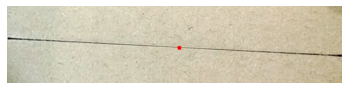

In [23]:
image=cv2.imread('line.jpg')
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
canny_edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)

# Find lines in the image
detected_lines = cv2.HoughLinesP(canny_edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

thinnest_point = None
thinnest_thickness = None
for line in detected_lines:
    x1, y1, x2, y2 = line[0]

    # Calculate average distance to non-edge pixels for thickness estimation
    distance = cv2.distanceTransform(canny_edges, cv2.DIST_L2, maskSize=5)  # Specify mask size
    line_mask = np.zeros_like(distance)
    cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)
    non_edge = distance[line_mask != 0]
    thickness = np.mean(non_edge)

    # Find center point
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Update if thinner point found
    if thinnest_thickness is None or thickness < thinnest_thickness:
        thinnest_point = (center_x, center_y)
        thinnest_thickness = thickness

# Draw the thinnest point and line segment
if thinnest_point is not None:
    cv2.circle(image, thinnest_point, 5, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


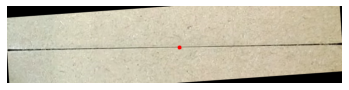

In [24]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection (if needed)
canny_edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)

# Detect lines using Hough Line Transform
detected_lines = cv2.HoughLines(canny_edges, 1, np.pi / 180, 100)

# Draw detected lines on a copy of the original image
line_image = np.copy(image)
for line in detected_lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Straighten the detected line
angle = theta * 180 / np.pi
if angle <45:
    angle += 90
else:
    angle -= 90

h, w = image.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

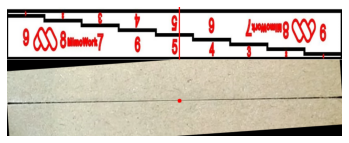

In [25]:
ruler_image = cv2.imread('focal.jpg')
if ruler_image is None:
    print("Error: Unable to load ruler image.")
    

# Resize the ruler image to match the width of the rotated image
resized_ruler_image = cv2.resize(ruler_image, (rotated_image.shape[1], ruler_image.shape[0]))
# Calculate the position of the thinnest point in the original image coordinates
orgi_img_thinnest_point = (int(thinnest_point[0] * (resized_ruler_image.shape[1] / rotated_image.shape[1])), int(thinnest_point[1] * (resized_ruler_image.shape[0] / rotated_image.shape[0])))

# Draw a vertical line on the ruler image at the position of the thinnest point
cv2.line(resized_ruler_image, (orgi_img_thinnest_point[0], 0), (orgi_img_thinnest_point[0], resized_ruler_image.shape[0]), (0, 0, 255), 2)

# Vertically concatenate the rotated image and the resized ruler image
combined_image = np.vstack((resized_ruler_image,rotated_image))
    
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [26]:
total_parts = 9
part_width = resized_ruler_image.shape[1] / total_parts
value = math.ceil(orgi_img_thinnest_point[0] / part_width)
print(f"Thin line is at the point: {value}mm")

Thin line is at the point: 5mm


In [27]:
speech= pp.init()

answer=f"The focal length is {value} mm"

speech.say(answer)
speech.runAndWait()